# Block DCT (Discrete Cosine Transform)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import image
import block_DCT as DCT
import YCoCg as YUV
#import RGB as YUV
import cv2
import distortion
import os
import pylab
import information
import deadzone as Q

In [2]:
#test_image = "../sequences/stockholm/"
test_image = "../sequences/lena_color/"
#test_image = "../sequences/lena_bw/"

In [3]:
block_y_side = block_x_side = 8

In [4]:
Q_steps = [128, 64, 32, 16]#, 8, 4, 2]

## Testing `block_DCT.analyze_block()` and `block_DCT.synthesize_block()`

In [5]:
#a = np.random.randint(low=0, high=100, size=(4,4,3))
a = np.full(shape=(4,4,3), fill_value=10, dtype=np.int16)

In [6]:
print(a)

[[[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]]


In [7]:
b = DCT.analyze_block(a)

In [8]:
print(b.astype(np.int16))

[[[40 40 40]
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]]


All the energy in each component has been accumulated in one coefficient.

In [9]:
c = DCT.synthesize_block(b)

In [10]:
print(c.astype(np.int16))

[[[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]]


As it can be seen, the transform is reversible.

## First ... some handy routines

In [11]:
def read_image(prefix):
    x = image.read(prefix, 0)
    if len(x.shape) == 2:
        extended_x = np.zeros(shape=(x.shape[0],  x.shape[1], 3), dtype=np.uint16) 
        extended_x[..., 0] = x
        return extended_x
    else:
        return x

def PNG_BPP(_image, prefix):
    image.write(_image, prefix, 0)
    fn = prefix + "000.png"
    codestream_length = os.path.getsize(fn)
    BPP = (8*codestream_length)/np.size(_image)
    if __debug__:
        __image = image.read(prefix, 0)
        return BPP, __image
    else:
        return BPP, None

def write_image(x, prefix):
    if len(x.shape) == 3:
        Y = x[..., 0]
        Y_len = image.save(Y, prefix + '_Y_', 0)
        U_donwsampled = cv2.pyrDown(x[..., 1])
        U_len = image.save(U_downsampled, prefix + '_U_', 0)
        V_downsampled = cv2.pyrDown(x[..., 2])
        V_len = image.save(V_downsampled, prefix + '_V_', 0)
        total_len = Y_len + U_len + V_len
    else:
        total_len = image.save(x, image_fn, 0)
    return (8*total_len)/np.size(x)

## Testing `DCT.analyze_image()` and `DCT.synthesize_image()`

image.read: ../sequences/lena_color/000.png (512, 512, 3) uint8 512673 
component 0 239 8 uint16
component 1 248 1 uint16
component 2 255 54 uint16


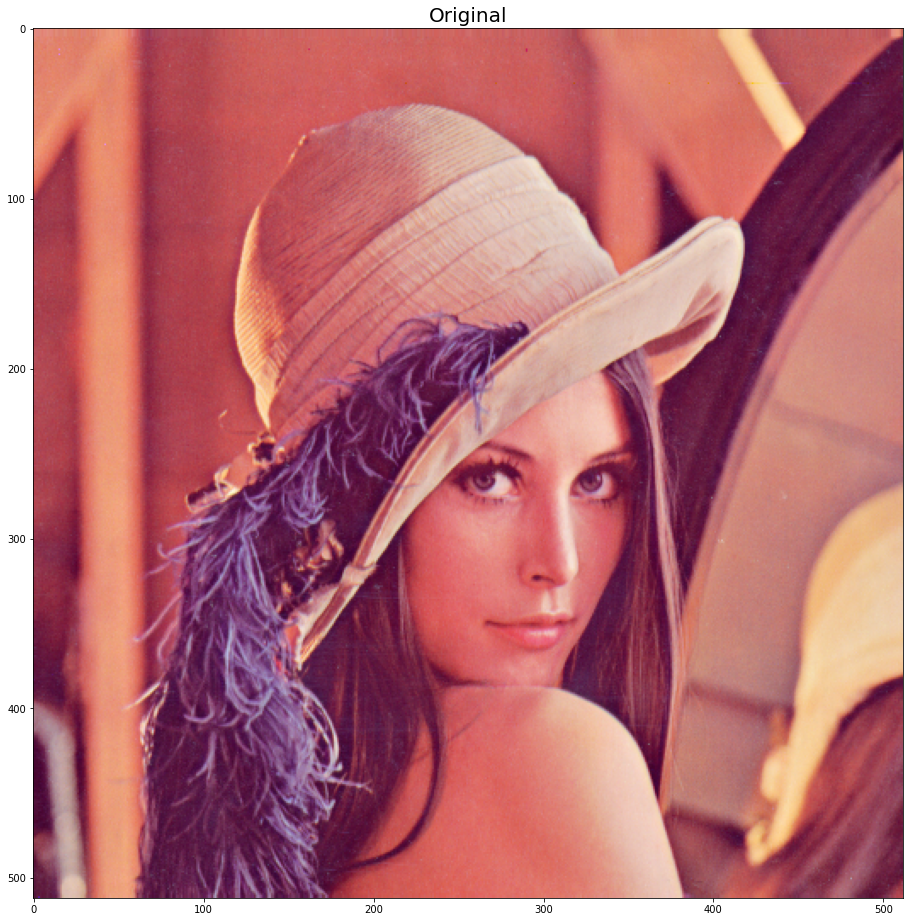

In [12]:
x = read_image(test_image)
    
#show_image(normalize(x))
image.show_RGB_image(x, title="Original")

In [13]:
y = DCT.analyze_image(x, block_y_side, block_x_side)

component 0 214.09572 13.006248 float32
component 1 227.75557 0.0 float32
component 2 255.0 6.5456166 float32
component 0 139.314 6.3745317 float32
component 1 166.50795 0.0 float32
component 2 255.0 6.1243277 float32


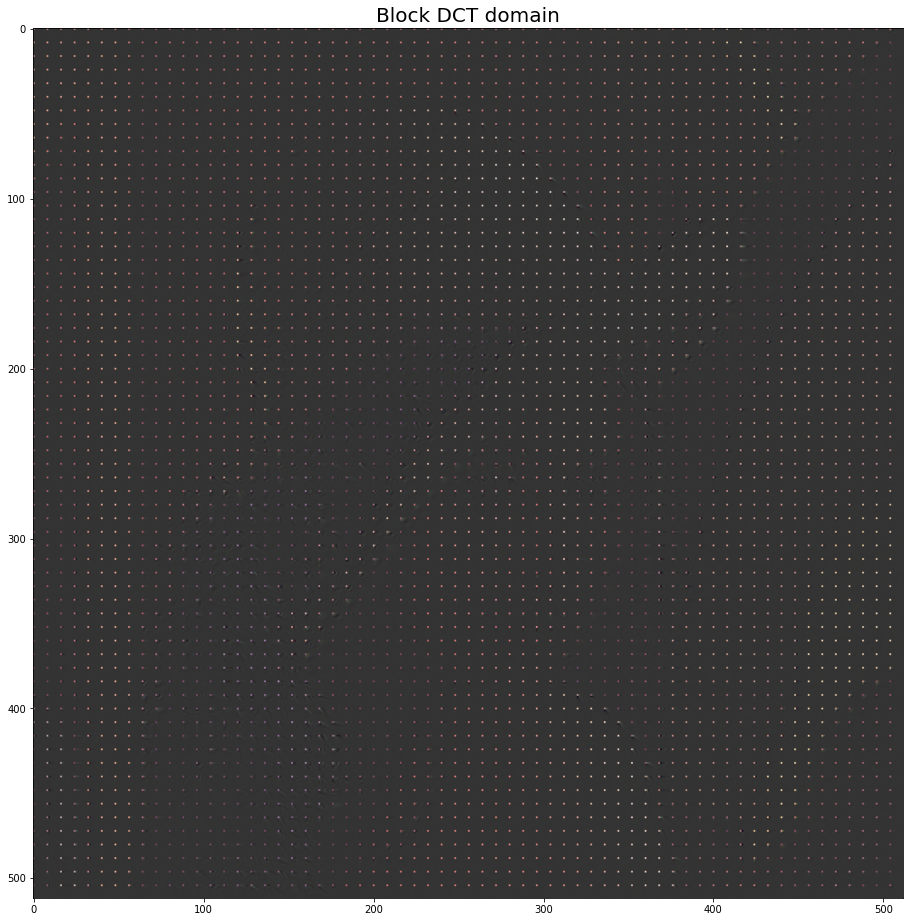

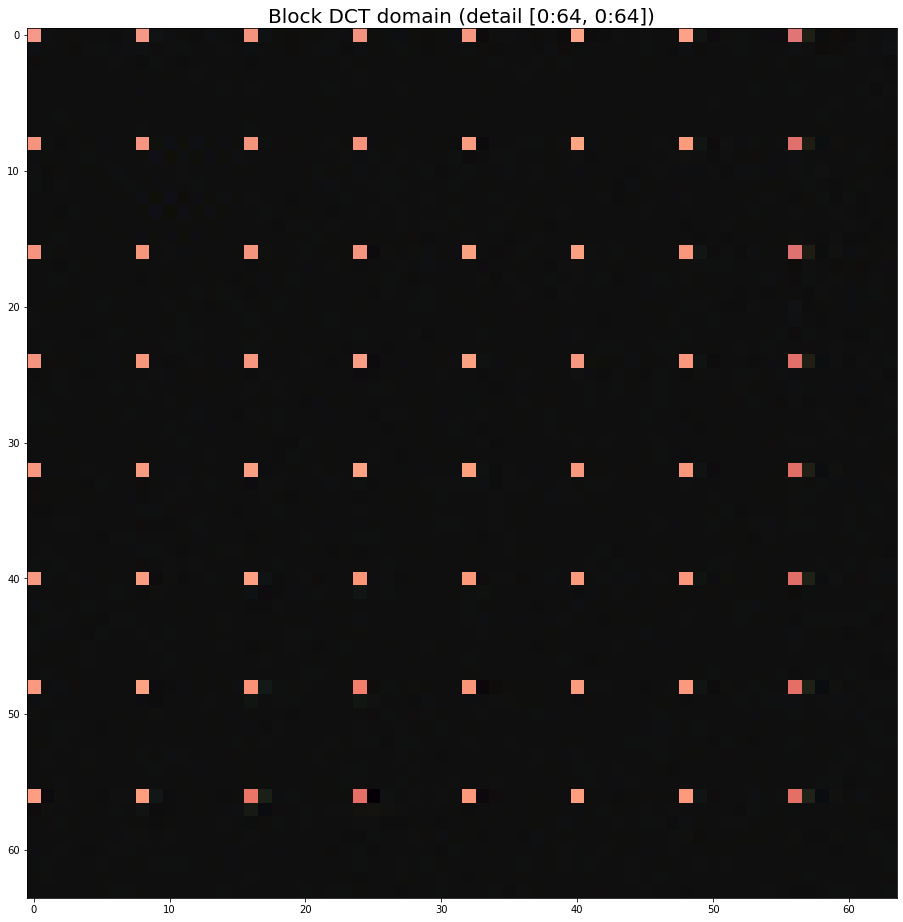

In [14]:
image.show_RGB_image(255*image.normalize(y), "Block DCT domain")
image.show_RGB_image(255*image.normalize(y[:64, :64]), "Block DCT domain (detail [0:64, 0:64])")

Again, most of the energy of each block has been concentrated in the low-pass frequency component (DC component).

In [15]:
z = DCT.synthesize_image(y, block_y_side, block_x_side)

In [16]:
r = x - z

component 0 255.0 0.0 float64
component 1 255.0 0.0 float64
component 2 255.0 0.0 float64


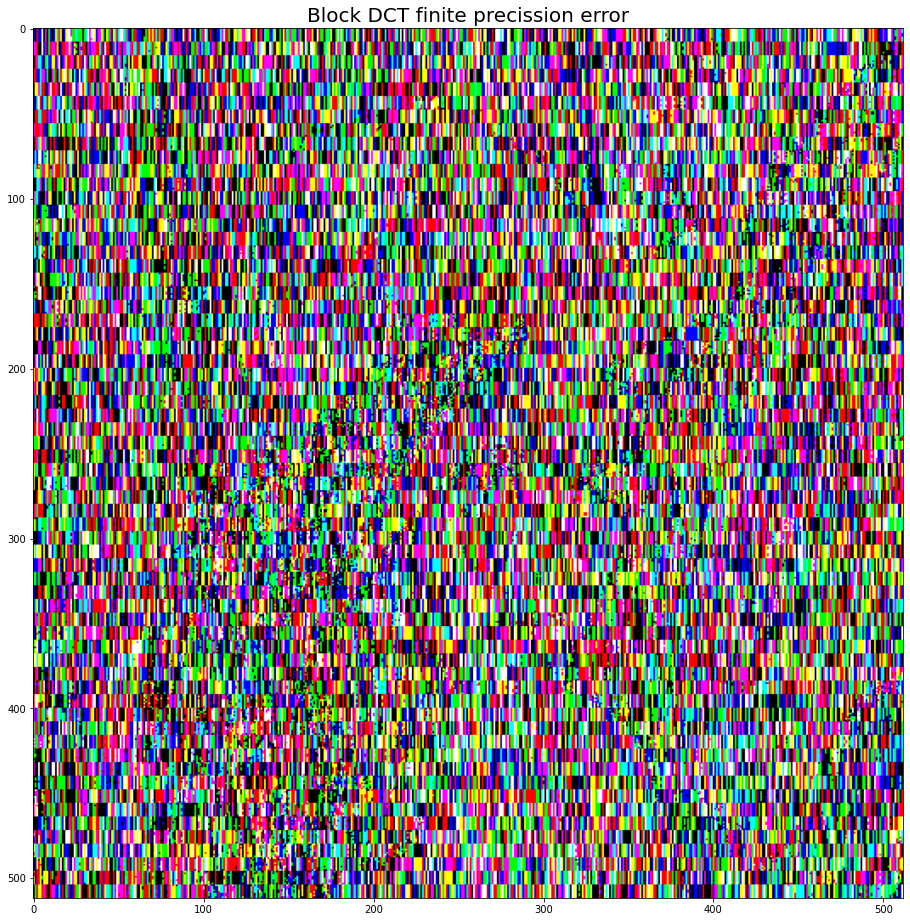

In [17]:
image.show_RGB_image(255*image.normalize(r), "Block DCT finite precission error")

In [18]:
r.max()

1

The DCT is not fully reversible, but it is almost.

component 0 239 7 int16
component 1 247 0 int16
component 2 255 54 int16


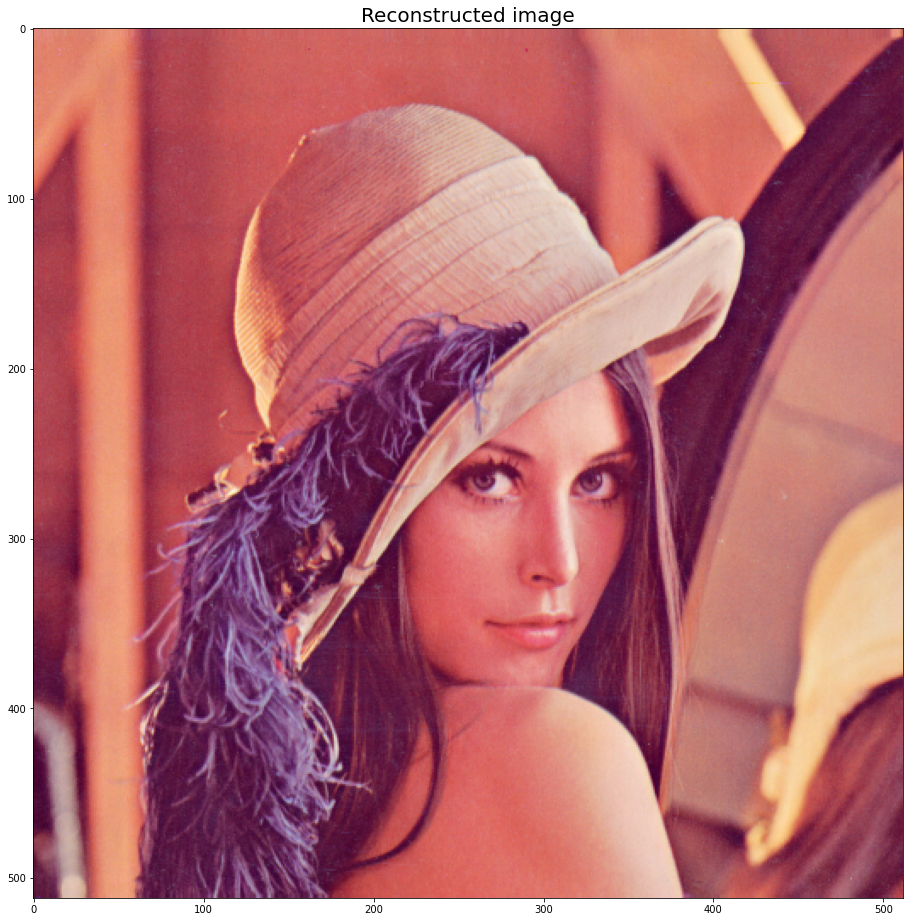

In [19]:
image.show_RGB_image(z, "Reconstructed image")

## Switching between blocks and subbands

The coefficients can be reorganized in subbands. A subband (X, Y) is the 2D concatenation of the coefficient that is in the coordinate (X, Y) of each block. The representation in subbands increases the spatial correlation between the coefficients (provides an improved visual comprehension of the image in the frequency domain).

In [20]:
x = read_image(test_image)
y = DCT.analyze_image(x, block_y_side, block_x_side)
y_subbands = DCT.get_subbands(y, block_y_side, block_x_side)
yy = DCT.get_blocks(y_subbands, block_y_side, block_x_side)
(yy == y).all()

image.read: ../sequences/lena_color/000.png (512, 512, 3) uint8 512673 


True

component 0 214.09572 13.006248 float32
component 1 227.75557 0.0 float32
component 2 255.0 6.5456166 float32


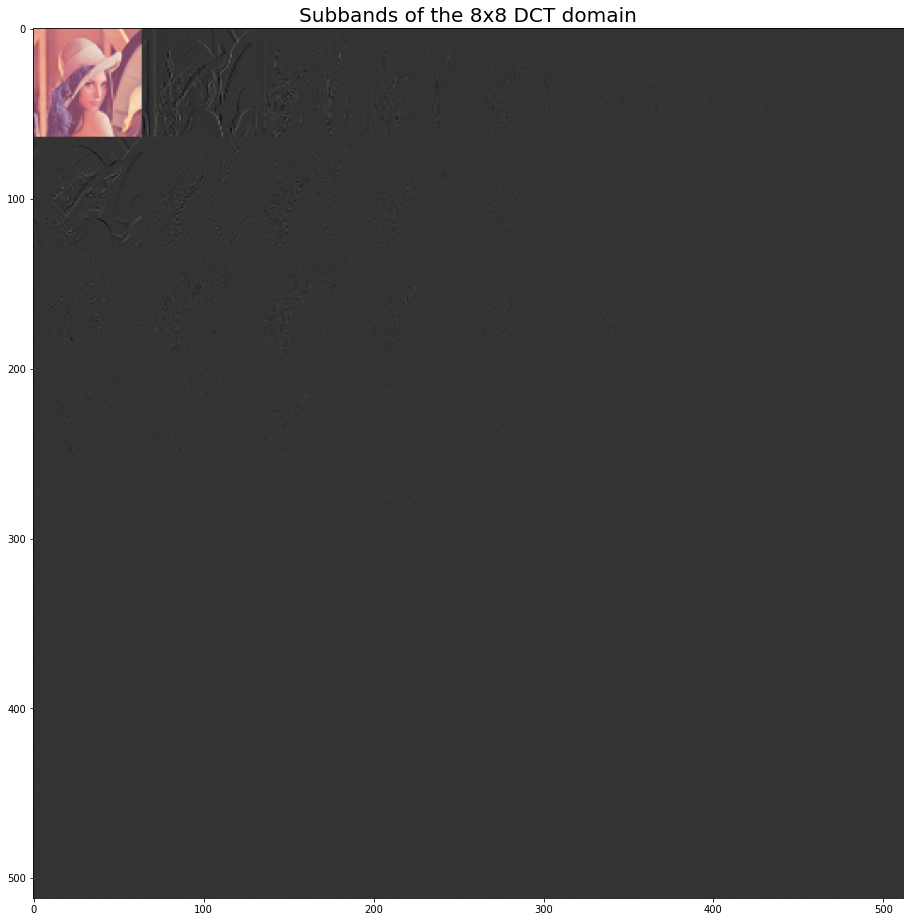

In [21]:
image.show_RGB_image(255*image.normalize(y_subbands), f"Subbands of the {block_y_side}x{block_x_side} DCT domain")

And it can be seen, the 2D correlation is higher in the low frequencies (left up corner) than in the high frequencies (right down corner).

component 0 201.44113 45.609623 float32
component 1 219.32693 0.0 float32
component 2 255.0 68.833244 float32


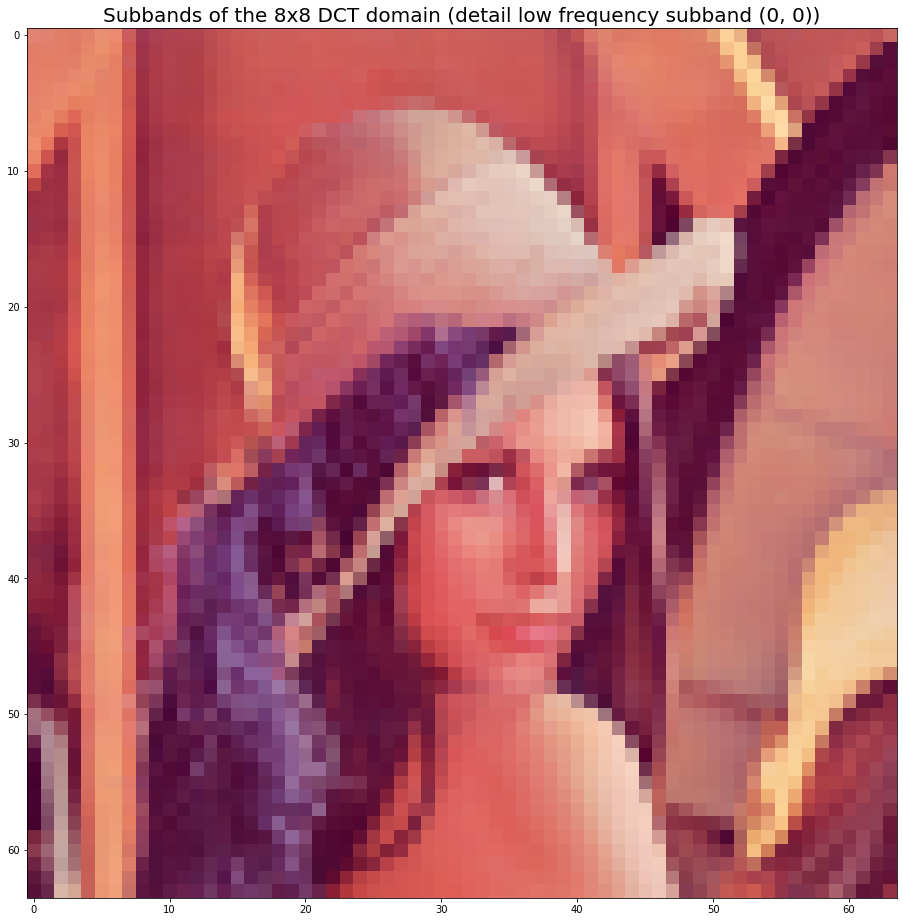

In [22]:
blocks_in_y = x.shape[0]//block_y_side
blocks_in_x = x.shape[1]//block_x_side
image.show_RGB_image(255*image.normalize(y_subbands[:blocks_in_y, :blocks_in_x]), f"Subbands of the {block_y_side}x{block_x_side} DCT domain (detail low frequency subband (0, 0))")

component 0 200.9766 41.61921 float32
component 1 255.0 0.0 float32
component 2 229.93929 13.6226225 float32


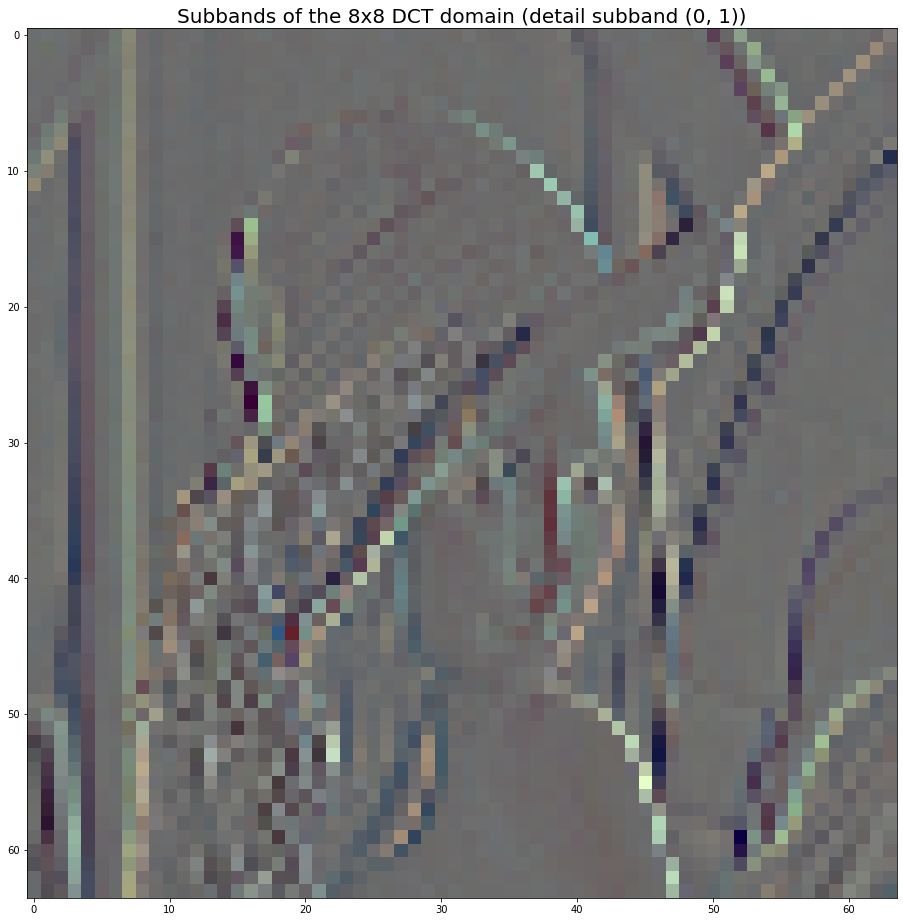

In [23]:
image.show_RGB_image(255*image.normalize(y_subbands[:blocks_in_y, blocks_in_x:2*blocks_in_x]), f"Subbands of the {block_y_side}x{block_x_side} DCT domain (detail subband (0, 1))")

The (0, 1) subband represents slow changes of signal in the horizontal domain.

component 0 226.5857 27.01756 float32
component 1 255.0 0.0 float32
component 2 234.80374 16.083572 float32


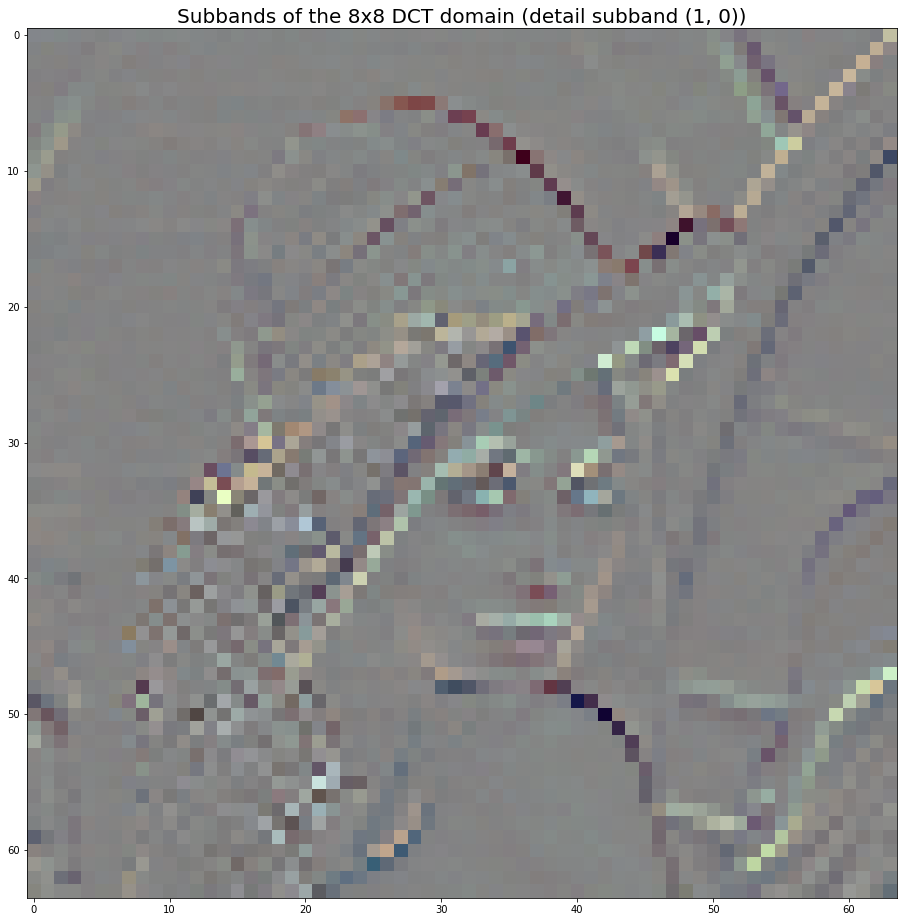

In [24]:
image.show_RGB_image(255*image.normalize(y_subbands[blocks_in_y:2*blocks_in_y, :blocks_in_x]), f"Subbands of the {block_y_side}x{block_x_side} DCT domain (detail subband (1, 0))")

The (1, 0) subband represents slow changes of signal in the vertical domain.

component 0 216.6641 40.961163 float32
component 1 255.0 0.0 float32
component 2 236.66275 27.574497 float32


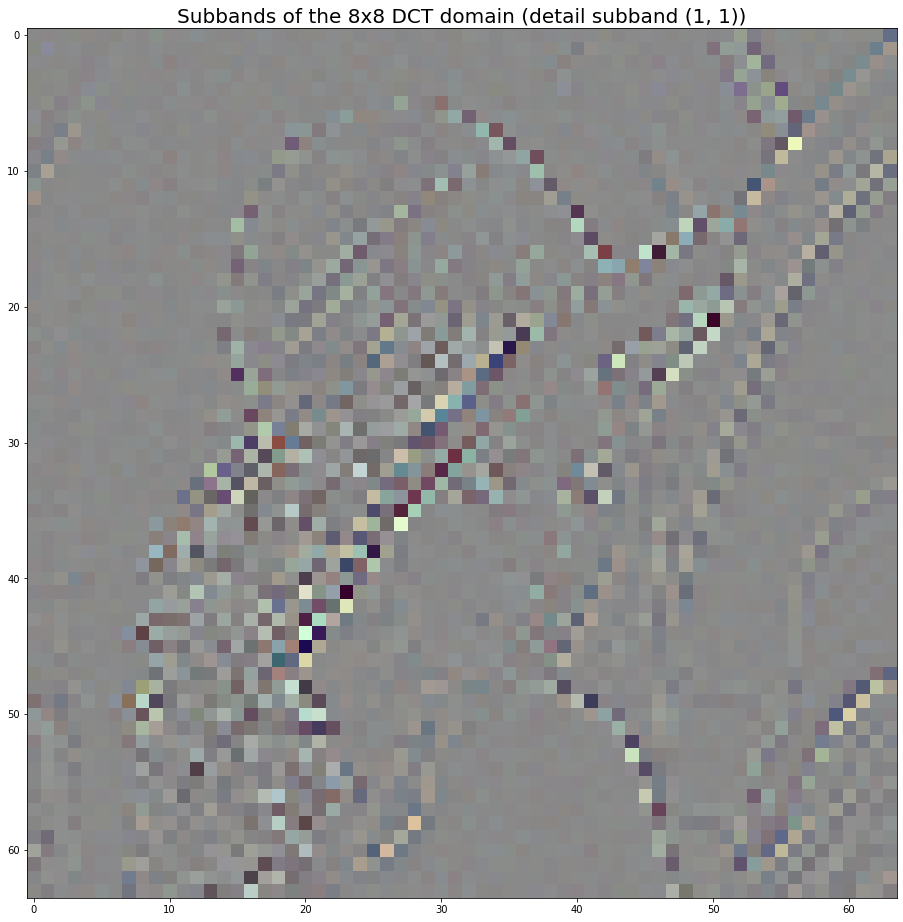

In [25]:
image.show_RGB_image(255*image.normalize(y_subbands[blocks_in_y:2*blocks_in_y, blocks_in_x:2*blocks_in_x]), f"Subbands of the {block_y_side}x{block_x_side} DCT domain (detail subband (1, 1))")

The (1, 1) subband represents slow changes of signal in the diagonal (left up corner to right down corner) domain.

## Testing `DCT.constant_quantize()` and `DCT.constant_dequantize()`
Quantization removes information but increases the compression ratios of the stored images. These methods quantize all coefficients with the same quantization step.

In [26]:
Q_step = 128
y = DCT.analyze_image(x, block_y_side, block_x_side)
y = DCT.get_subbands(y, block_y_side, block_x_side)
y_Q = DCT.constant_quantize(y, block_y_side, block_x_side, Q_step)
y_Q = DCT.constant_dequantize(y_Q, block_y_side, block_x_side, Q_step)
y_Q = DCT.get_blocks(y_Q, block_y_side, block_x_side)
z_Q = DCT.synthesize_image(y_Q, block_y_side, block_x_side)

component 0 220 29 int16
component 1 252 0 int16
component 2 255 27 int16


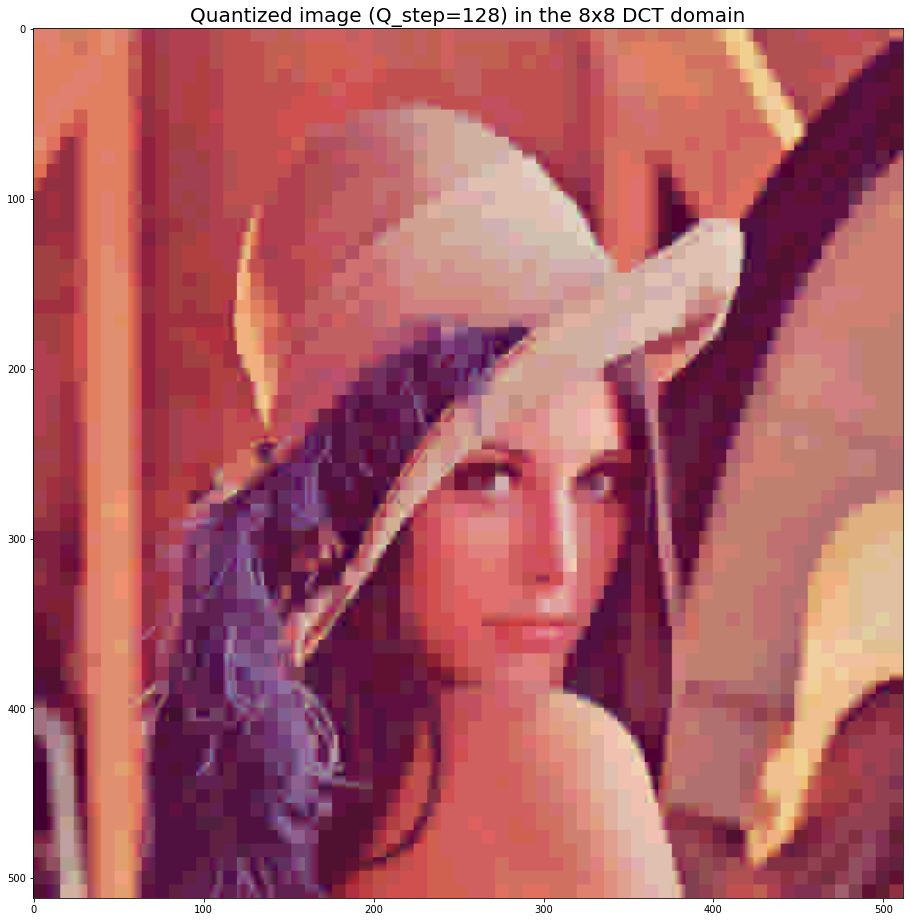

In [27]:
image.show_RGB_image(np.clip(z_Q, a_max=255, a_min=0), f"Quantized image (Q_step={Q_step}) in the {block_y_side}x{block_x_side} DCT domain")

component 0 233.36363636363637 47.90909090909091 float64
component 1 255.0 0.0 float64
component 2 228.72727272727272 14.681818181818183 float64


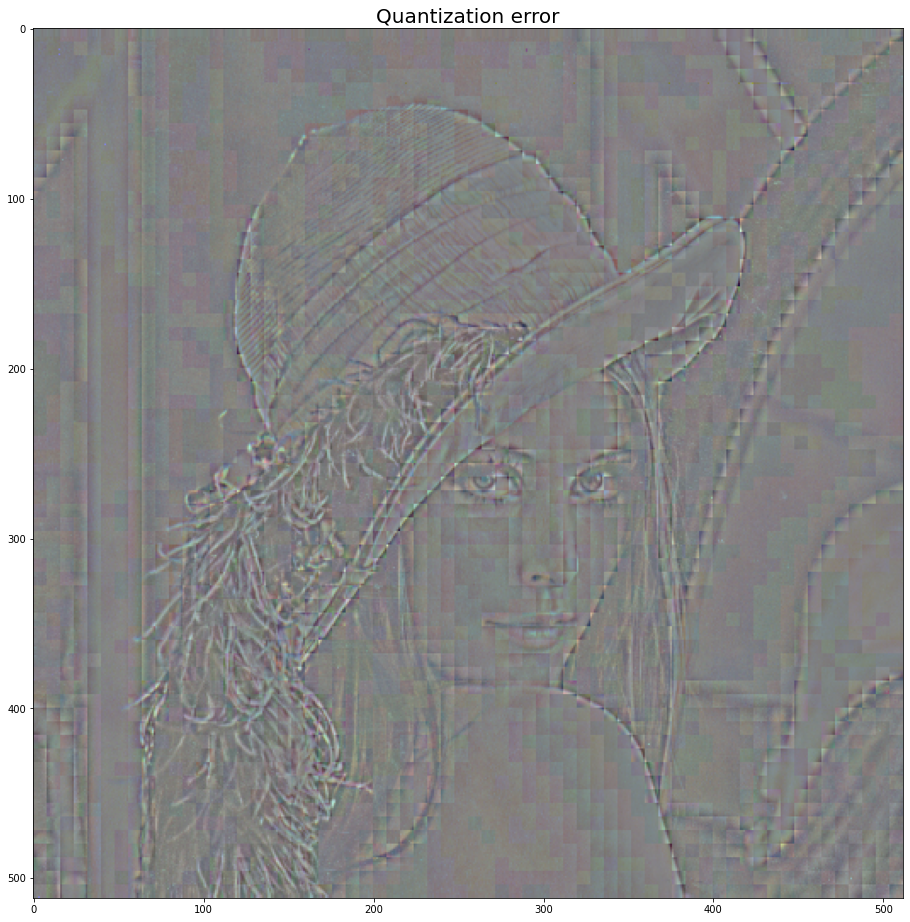

In [28]:
r = x - z_Q
n = image.normalize(r)
image.show_RGB_image(255*n, "Quantization error")

Quantization in the DCT domain tends to remove high frequencies (it works basically as a low pass filter).

## Coding subbands vs coding blocks
Let's see the effect of encoding the DCT coefficients grouped by subbands. For simplicity, we will use constant quantization.

In [29]:
xx = read_image(test_image).astype(np.int16) - 128
x = YUV.from_RGB(xx)
print(x[...,0].max(),x[...,0].min())
print(x[...,1].max(),x[...,1].min())
print(x[...,2].max(),x[...,2].min())

RD_points_blocks = []
RD_points_subbands = []
for Q_step in Q_steps:
    y = DCT.analyze_image(x, block_y_side, block_x_side)
    # Notice that with constant_quantize() does not matter if the DCT domain
    # is organized in subbands or blocks.
    y_Q = DCT.constant_quantize(y, block_y_side, block_x_side, Q_step)
    y_dQ = DCT.constant_dequantize(y_Q, block_y_side, block_x_side, Q_step)
    z_dQ = DCT.synthesize_image(y_dQ, block_y_side, block_x_side)
    zz_dQ = YUV.to_RGB(z_dQ)
    BPP, _y_Q = information.PNG_BPP((y_Q.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/{Q_step}_")
    assert (y_Q == _y_Q.astype(np.int32) - 32768).all()
    # Notice that to compute the distortion, the DCT domain could be
    # also used.
    MSE = distortion.MSE(xx, zz_dQ)
    RD_points_blocks.append((BPP, MSE))
    y_Q_subbands = DCT.get_subbands(y_Q, block_y_side, block_x_side)
    BPP, _y_Q_subbands = information.PNG_BPP((y_Q_subbands.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/s_{Q_step}_")
    assert (y_Q_subbands == _y_Q_subbands.astype(np.int32) - 32768).all()
    RD_points_subbands.append((BPP, MSE))
    print(Q_step, end=' ', flush=True)

image.read: ../sequences/lena_color/000.png (512, 512, 3) uint8 512673 
113 -100
48 -117
33 -60
image.write: /tmp/128_000.png (512, 512, 3) uint16 28903 
image.read: /tmp/128_000.png (512, 512, 3) uint16 28903 
image.write: /tmp/s_128_000.png (512, 512, 3) uint16 11461 
image.read: /tmp/s_128_000.png (512, 512, 3) uint16 11461 
128 image.write: /tmp/64_000.png (512, 512, 3) uint16 41596 
image.read: /tmp/64_000.png (512, 512, 3) uint16 41596 
image.write: /tmp/s_64_000.png (512, 512, 3) uint16 19649 
image.read: /tmp/s_64_000.png (512, 512, 3) uint16 19649 
64 image.write: /tmp/32_000.png (512, 512, 3) uint16 59414 
image.read: /tmp/32_000.png (512, 512, 3) uint16 59414 
image.write: /tmp/s_32_000.png (512, 512, 3) uint16 34549 
image.read: /tmp/s_32_000.png (512, 512, 3) uint16 34549 
32 image.write: /tmp/16_000.png (512, 512, 3) uint16 89967 
image.read: /tmp/16_000.png (512, 512, 3) uint16 89967 
image.write: /tmp/s_16_000.png (512, 512, 3) uint16 63523 
image.read: /tmp/s_16_000.pn

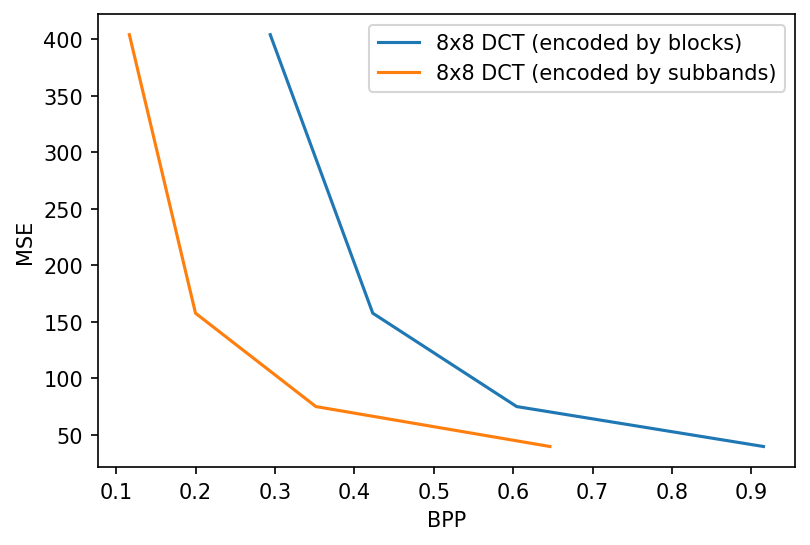

In [30]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points_blocks), label=f"{block_y_side}x{block_x_side} DCT (encoded by blocks)")
pylab.plot(*zip(*RD_points_subbands), label=f"{block_y_side}x{block_x_side} DCT (encoded by subbands)")
pylab.title("")
pylab.xlabel("BPP")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

## Can we do it better?
The performance of any image compressor depends on how much of the original information can be stored in the code-stream. In other words, the performance is proportional to the amount of distortion accumulated in the decoded image divided by the length of the code-stream (notice that the lower the distortion, the higher the performance, and the lower the length, the higher again the performance). This is exactly what an *operational* R/D curve of the image represents.

The amount of distortion generated is controlled the quantization. The DCT is a linear transform, i.e., the quantization error (that can be considered as a random signal added to the original image) is the same in both the image and the transform domain (we will check that). Moreover, because the subbands generated by the DCT have the same gain (we will also check that), the constant quantization of all the subbands generates the same amount of distortion in all the subbands. Notice that the quantization error does not depends on the dynamic range of the signal, but only on the quantization step.

However, not always all the subbands are equally compressible. For example, if after a constant quantization all the coefficients of a subband become zero or very close to this value (because the energy of this subband is small compared to the quantization step), the cost of representing such subband in the code-stream will be low. Therefore, even if the contribution of this subband to the quality of the reconstructed image is small compared to other subbands, the contribution of its compressed representation can be significative.

An important question that arises here is: are the contributions of the subbands to the quality of the reconstructed image independent? If the transform is orthogonal (something that we will check), the answer is yes. Thanks to the contributions are independent, we can assume that the quantization error generated in one subband does not influence on the quantization error added the other subbands, and therefore, we can optimize (search) the quantization step in each subband, independently, by using the same slope in the R/D curve of the subband  (selecting the quantization step).

Remember that each subband has the same gain (all the subbands generates the same quantization error when a constant quantization step is used) and that the transform is linear (the distortion can be measured equally in the image and the transform domain). Therefore, we can use the RD curves of the subbands that represents how the distortion of the subband decreases with the length of the code-stream of the subband. Thanks to this, we will not need to compute the inverse transform to measure the impact of quantization.

For the sake of simplicity in the rest of experiments, we will only suppose that the available quantization steps are {128, 64, 32, 16, 8, 4, 2 and 1}. Usually, this produces a RD curve whose points are equally distant (more or less) in the rate domain.

## Determination of the operational RD curve of each subband

In [31]:
xx = read_image(test_image).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = DCT.analyze_image(x, block_y_side, block_x_side)
y_sbs = DCT.get_subbands(y, block_y_side, block_x_side)
blocks_in_y = y.shape[0]//block_y_side
blocks_in_x = y.shape[1]//block_x_side
image_energy = distortion.average_energy(x) # DCT is unitary, i.e., energy(x) = energy(y)
print(distortion.average_energy(y))

# Create a list of lists. The first dimension is the subband and the second
# dimension is the point of the operational RD curve of the subband.
RD_points = []
RD_slopes = []
for i in range(block_y_side):
    for j in range(block_x_side):
        sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                   blocks_in_x*j:blocks_in_x*(j+1)]
        subband_energy = distortion.average_energy(sb)
        # The first point of each RD curve has a maximum distortion equal
        # to the energy of the subband and a rate = 0
        RD_points.append([(0, subband_energy)])
        RD_slopes.append([])
        
# Now populate the rest of points of each subband
for i in range(block_y_side):
    for j in range(block_x_side):
        sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                   blocks_in_x*j:blocks_in_x*(j+1)]
        counter = 0
        for Q_step in Q_steps:
            Q_indexes = Q.quantize(sb, Q_step)
            Q_coefs = Q.dequantize(Q_indexes, Q_step)
            MSE_Q_coefs = distortion.MSE(sb, Q_coefs)
            BPP_Q_indexes = information.PNG_BPP((Q_indexes.astype(np.int32) + 32768).astype(np.uint16), "/tmp/BPP_")[0]
            #BPP_Q_indexes = information.entropy(Q_indexes.astype(np.int16).flatten())
            RD_points[i * block_x_side + j].append((BPP_Q_indexes, MSE_Q_coefs))
            delta_BPP = BPP_Q_indexes - RD_points[i * block_x_side + j][counter][0]
            delta_MSE = RD_points[i * block_x_side + j][counter][1] - MSE_Q_coefs
            if delta_BPP > 0:
                slope = delta_MSE/delta_BPP
            else:
                slope = 0
            RD_slopes[i * block_x_side + j].append((Q_step, slope, (i, j)))
            counter += 1

image.read: ../sequences/lena_color/000.png (512, 512, 3) uint8 512673 
1439.2267634482232
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 4647 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 4647 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 6026 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 6026 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 7604 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 7604 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 9349 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 9349 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 1664 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 1664 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 3142 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 3142 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 4843 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 4843 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 7031 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 7031 
image.write: /tmp/BPP_000.png (64, 64

image.read: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 311 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 311 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 512 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 512 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 350 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 350 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 655 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 655 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 1316 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 1316 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 2416 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 2416 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 330 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 330 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 704 
image.read: /tmp/BPP_000.png (64,

image.write: /tmp/BPP_000.png (64, 64, 3) uint16 314 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 314 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 547 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 547 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 357 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 357 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 311 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 311 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 416 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 416 
image.write: /tmp/BPP_000.png (64, 64

image.read: /tmp/BPP_000.png (64, 64, 3) uint16 401 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 342 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 342 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 338 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 338 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.read: /tmp/BPP_000.png (64, 64,

image.read: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 306 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 306 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 312 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 312 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.read: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.write: /tmp/BPP_000.png (64, 64, 3) uint16 295 
image.read: /tmp/BPP_000.png (64, 64,

In [32]:
if block_y_side < 8:
    pylab.figure(dpi=150)
    for i in range(block_y_side):
        for j in range(block_x_side):
            pylab.plot(*zip(*RD_points[i * block_x_side + j]), label=f"{i} {j}", marker=f"{i+1}")
    pylab.title("RD curves of the subbands")
    pylab.xlabel("Bits/Pixel")
    pylab.ylabel("MSE")
    plt.legend(loc="best")
    pylab.show()

In [33]:
if block_y_side < 8:
    pylab.figure(dpi=150)
    for i in range(block_y_side):
        for j in range(block_x_side):
            pylab.plot(*zip(*RD_points[i * block_x_side + j]), label=f"{i} {j}", marker=f"{i+1}")
    pylab.title("RD curves of the subbands")
    pylab.xlabel("Bits/Pixel")
    pylab.ylabel("MSE")
    pylab.yscale("log")
    plt.legend(loc="best")
    pylab.show()

As it can be seen, the slope of all the subband is approximately the same, except for the subband (0, 0). This result sugests that the subband (0, 0) should be encoded first with Q_step=1 and then, use a constant quantization stage for the rest of subbands.

In [34]:
subband = 0
Q_step_index = 0
RD_slopes[subband][Q_step_index][0:2]

(128, 26379.481816225518)

In [35]:
RD_slopes_without_sb_index = []
for i in range(block_y_side):
    for j in range(block_x_side):
        RD_slopes_without_sb_index.append([])
for i in range(block_y_side):
    for j in range(block_x_side):
        for Q_step in range(len(Q_steps)):
            #print(RD_slopes[i * block_x_side + j][Q_step][0:2])
            RD_slopes_without_sb_index[i * block_x_side + j].append(RD_slopes[i * block_x_side + j][Q_step][0:2])

if block_y_side < 8:
    pylab.figure(dpi=150)
    for i in range(block_y_side):
        for j in range(block_x_side):
            pylab.plot(*zip(*RD_slopes_without_sb_index[i * block_x_side + j]), label=f"{i} {j}", marker=f"{i+1}")
    pylab.title("Slopes of the RD curves of the subbands")
    pylab.xlabel("Q_step")
    pylab.ylabel("Slope")
    plt.legend(loc="best")
    pylab.show()

In [36]:
if block_y_side < 8:
    pylab.figure(dpi=150)
    for i in range(block_y_side):
        for j in range(block_x_side):
            pylab.plot(*zip(*RD_slopes_without_sb_index[i * block_x_side + j]), label=f"{i} {j}", marker=f"{i+1}")
    pylab.title("Slopes of the RD curves of the subbands")
    pylab.xlabel("Q_step")
    pylab.ylabel("Slope")
    pylab.yscale("log")
    plt.legend(loc="best")
    pylab.show()

These results show that the subband that constributes the most to the quality of the reconstruction is [0, 0], followed by [0, 1] and [1, 0].

Let's sort the slopes.

In [37]:
RD_slopes

[[(128, 26379.481816225518, (0, 0)),
  (64, 5088.684554024655, (0, 0)),
  (32, 952.7972116603298, (0, 0)),
  (16, 227.97020057306582, (0, 0))],
 [(128, 1451.8081967280461, (0, 1)),
  (64, 531.2550581543632, (0, 1)),
  (32, 214.7971347313218, (0, 1)),
  (16, 68.33619889393584, (0, 1))],
 [(128, 482.50041232638887, (0, 2)),
  (64, 345.70055286476446, (0, 2)),
  (32, 126.67296087802984, (0, 2)),
  (16, 48.19575721314238, (0, 2))],
 [(128, 112.32722843838269, (0, 3)),
  (64, 223.13695149249344, (0, 3)),
  (32, 97.1719454887218, (0, 3)),
  (16, 34.9690760969018, (0, 3))],
 [(128, 11.800664451827243, (0, 4)),
  (64, 170.15217391304355, (0, 4)),
  (32, 71.36380597014924, (0, 4)),
  (16, 29.447698744769866, (0, 4))],
 [(128, 0.0, (0, 5)),
  (64, 136.33979679987982, (0, 5)),
  (32, 51.485730238363764, (0, 5)),
  (16, 21.81565569288136, (0, 5))],
 [(128, 0.0, (0, 6)),
  (64, 90.37974196213908, (0, 6)),
  (32, 41.53918160965193, (0, 6)),
  (16, 17.384903971354177, (0, 6))],
 [(128, 0.0, (0, 7)),


In [38]:
single_list = []
for i in range(block_y_side):
    for j in range(block_x_side):
        for Q_step in range(len(Q_steps)):
            #print(RD_slopes[i * block_x_side + j][Q_step][0:2])
            single_list.append(tuple(RD_slopes[i * block_x_side + j][Q_step]))

In [39]:
single_list

[(128, 26379.481816225518, (0, 0)),
 (64, 5088.684554024655, (0, 0)),
 (32, 952.7972116603298, (0, 0)),
 (16, 227.97020057306582, (0, 0)),
 (128, 1451.8081967280461, (0, 1)),
 (64, 531.2550581543632, (0, 1)),
 (32, 214.7971347313218, (0, 1)),
 (16, 68.33619889393584, (0, 1)),
 (128, 482.50041232638887, (0, 2)),
 (64, 345.70055286476446, (0, 2)),
 (32, 126.67296087802984, (0, 2)),
 (16, 48.19575721314238, (0, 2)),
 (128, 112.32722843838269, (0, 3)),
 (64, 223.13695149249344, (0, 3)),
 (32, 97.1719454887218, (0, 3)),
 (16, 34.9690760969018, (0, 3)),
 (128, 11.800664451827243, (0, 4)),
 (64, 170.15217391304355, (0, 4)),
 (32, 71.36380597014924, (0, 4)),
 (16, 29.447698744769866, (0, 4)),
 (128, 0.0, (0, 5)),
 (64, 136.33979679987982, (0, 5)),
 (32, 51.485730238363764, (0, 5)),
 (16, 21.81565569288136, (0, 5)),
 (128, 0.0, (0, 6)),
 (64, 90.37974196213908, (0, 6)),
 (32, 41.53918160965193, (0, 6)),
 (16, 17.384903971354177, (0, 6)),
 (128, 0.0, (0, 7)),
 (64, 0, (0, 7)),
 (32, 41.674901788

In [40]:
sorted_slopes = sorted(single_list, key=lambda x: x[1])[::-1]

In [41]:
sorted_slopes

[(128, 26379.481816225518, (0, 0)),
 (64, 5088.684554024655, (0, 0)),
 (128, 1451.8081967280461, (0, 1)),
 (32, 952.7972116603298, (0, 0)),
 (128, 922.1431588618716, (1, 0)),
 (64, 531.2550581543632, (0, 1)),
 (128, 482.50041232638887, (0, 2)),
 (64, 425.58006008860633, (1, 0)),
 (128, 406.40990958378245, (1, 1)),
 (64, 345.70055286476446, (0, 2)),
 (64, 318.52360550125485, (1, 1)),
 (64, 265.99904918218675, (1, 2)),
 (64, 247.68210329149588, (2, 0)),
 (64, 235.23338766659015, (2, 1)),
 (64, 230.42899879834323, (2, 2)),
 (16, 227.97020057306582, (0, 0)),
 (64, 226.7081787109365, (2, 5)),
 (64, 223.13695149249344, (0, 3)),
 (32, 214.7971347313218, (0, 1)),
 (64, 214.69996244744607, (1, 3)),
 (64, 187.89113362630204, (3, 0)),
 (64, 173.55499653876572, (3, 1)),
 (64, 170.15217391304355, (0, 4)),
 (64, 165.82676073531033, (2, 3)),
 (32, 158.78600671636593, (1, 0)),
 (128, 150.5181906289358, (1, 2)),
 (64, 139.21506420534052, (3, 2)),
 (64, 139.17362406716413, (1, 4)),
 (64, 136.33979679987

As it can be seen, the constant quantization step is not optimal, but it's performance is not bad because the sorted slopes are highly correlated with the quantization step.

Let's implement now the optimal quantization progression.

## Optimal quantization progression

Let's plot the optimal RD curve. Using the quantization steps defined in the list of sorted slopes, we will perform a reconstruction for each slope, measuring the distortion and the bit-rate.

In [42]:
optimal_RD_points = []
y_prog = np.zeros_like(y_sbs)
Q_steps = np.full(shape=(block_x_side, block_y_side), fill_value=99999999)
for s in sorted_slopes:
    subband = s[2]
    i = subband[0]
    j = subband[1]
    Q_steps[i, j] = s[0]
    print(subband, Q_steps[i, j])
    y_prog[blocks_in_y*i:blocks_in_y*(i+1),
           blocks_in_x*j:blocks_in_x*(j+1)] = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                                                    blocks_in_x*j:blocks_in_x*(j+1)]
    y_quant = DCT.quantize(y_prog, block_y_side, block_x_side, Q_steps)
    y_dequant = DCT.dequantize(y_quant, block_y_side, block_x_side, Q_steps)
    y_dequant = DCT.get_blocks(y_dequant, block_y_side, block_x_side)
    z_prog = DCT.synthesize_image(y_dequant, block_y_side, block_x_side)
    # If the color transform domain is not linear, the MSE should be measured in the RGB domain
    MSE = distortion.MSE(x, z_prog)
    BPP, _y_quant = information.PNG_BPP((y_quant.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/{i}_{j}_{Q_step}_")
    assert (y_quant == _y_quant.astype(np.int32) - 32768).all()
    optimal_RD_points.append((BPP, MSE))

(0, 0) 128
image.write: /tmp/0_0_3_000.png (512, 512, 3) uint16 9184 
image.read: /tmp/0_0_3_000.png (512, 512, 3) uint16 9184 
(0, 0) 64
image.write: /tmp/0_0_3_000.png (512, 512, 3) uint16 9963 
image.read: /tmp/0_0_3_000.png (512, 512, 3) uint16 9963 
(0, 1) 128
image.write: /tmp/0_1_3_000.png (512, 512, 3) uint16 11940 
image.read: /tmp/0_1_3_000.png (512, 512, 3) uint16 11940 
(0, 0) 32
image.write: /tmp/0_0_3_000.png (512, 512, 3) uint16 14106 
image.read: /tmp/0_0_3_000.png (512, 512, 3) uint16 14106 
(1, 0) 128
image.write: /tmp/1_0_3_000.png (512, 512, 3) uint16 14762 
image.read: /tmp/1_0_3_000.png (512, 512, 3) uint16 14762 
(0, 1) 64
image.write: /tmp/0_1_3_000.png (512, 512, 3) uint16 16198 
image.read: /tmp/0_1_3_000.png (512, 512, 3) uint16 16198 
(0, 2) 128
image.write: /tmp/0_2_3_000.png (512, 512, 3) uint16 16499 
image.read: /tmp/0_2_3_000.png (512, 512, 3) uint16 16499 
(1, 0) 64
image.write: /tmp/1_0_3_000.png (512, 512, 3) uint16 17149 
image.read: /tmp/1_0_3_000.

image.write: /tmp/3_1_3_000.png (512, 512, 3) uint16 35809 
image.read: /tmp/3_1_3_000.png (512, 512, 3) uint16 35809 
(2, 1) 128
image.write: /tmp/2_1_3_000.png (512, 512, 3) uint16 34765 
image.read: /tmp/2_1_3_000.png (512, 512, 3) uint16 34765 
(1, 4) 32
image.write: /tmp/1_4_3_000.png (512, 512, 3) uint16 35125 
image.read: /tmp/1_4_3_000.png (512, 512, 3) uint16 35125 
(2, 4) 32
image.write: /tmp/2_4_3_000.png (512, 512, 3) uint16 35327 
image.read: /tmp/2_4_3_000.png (512, 512, 3) uint16 35327 
(1, 0) 16
image.write: /tmp/1_0_3_000.png (512, 512, 3) uint16 37242 
image.read: /tmp/1_0_3_000.png (512, 512, 3) uint16 37242 
(3, 3) 32
image.write: /tmp/3_3_3_000.png (512, 512, 3) uint16 37487 
image.read: /tmp/3_3_3_000.png (512, 512, 3) uint16 37487 
(3, 4) 32
image.write: /tmp/3_4_3_000.png (512, 512, 3) uint16 37620 
image.read: /tmp/3_4_3_000.png (512, 512, 3) uint16 37620 
(0, 5) 32
image.write: /tmp/0_5_3_000.png (512, 512, 3) uint16 37809 
image.read: /tmp/0_5_3_000.png (512,

image.write: /tmp/4_0_3_000.png (512, 512, 3) uint16 56765 
image.read: /tmp/4_0_3_000.png (512, 512, 3) uint16 56765 
(4, 3) 16
image.write: /tmp/4_3_3_000.png (512, 512, 3) uint16 57339 
image.read: /tmp/4_3_3_000.png (512, 512, 3) uint16 57339 
(4, 2) 16
image.write: /tmp/4_2_3_000.png (512, 512, 3) uint16 57913 
image.read: /tmp/4_2_3_000.png (512, 512, 3) uint16 57913 
(0, 6) 16
image.write: /tmp/0_6_3_000.png (512, 512, 3) uint16 58359 
image.read: /tmp/0_6_3_000.png (512, 512, 3) uint16 58359 
(4, 4) 16
image.write: /tmp/4_4_3_000.png (512, 512, 3) uint16 58682 
image.read: /tmp/4_4_3_000.png (512, 512, 3) uint16 58682 
(3, 5) 16
image.write: /tmp/3_5_3_000.png (512, 512, 3) uint16 58996 
image.read: /tmp/3_5_3_000.png (512, 512, 3) uint16 58996 
(1, 6) 16
image.write: /tmp/1_6_3_000.png (512, 512, 3) uint16 59335 
image.read: /tmp/1_6_3_000.png (512, 512, 3) uint16 59335 
(0, 7) 16
image.write: /tmp/0_7_3_000.png (512, 512, 3) uint16 59558 
image.read: /tmp/0_7_3_000.png (512, 

image.read: /tmp/7_3_3_000.png (512, 512, 3) uint16 60588 
(7, 3) 128
image.write: /tmp/7_3_3_000.png (512, 512, 3) uint16 60588 
image.read: /tmp/7_3_3_000.png (512, 512, 3) uint16 60588 
(7, 2) 32
image.write: /tmp/7_2_3_000.png (512, 512, 3) uint16 60575 
image.read: /tmp/7_2_3_000.png (512, 512, 3) uint16 60575 
(7, 2) 64
image.write: /tmp/7_2_3_000.png (512, 512, 3) uint16 60575 
image.read: /tmp/7_2_3_000.png (512, 512, 3) uint16 60575 
(7, 2) 128
image.write: /tmp/7_2_3_000.png (512, 512, 3) uint16 60575 
image.read: /tmp/7_2_3_000.png (512, 512, 3) uint16 60575 
(7, 1) 32
image.write: /tmp/7_1_3_000.png (512, 512, 3) uint16 60561 
image.read: /tmp/7_1_3_000.png (512, 512, 3) uint16 60561 
(7, 1) 64
image.write: /tmp/7_1_3_000.png (512, 512, 3) uint16 60561 
image.read: /tmp/7_1_3_000.png (512, 512, 3) uint16 60561 
(7, 1) 128
image.write: /tmp/7_1_3_000.png (512, 512, 3) uint16 60561 
image.read: /tmp/7_1_3_000.png (512, 512, 3) uint16 60561 
(7, 0) 32
image.write: /tmp/7_0_3_0

image.read: /tmp/5_0_3_000.png (512, 512, 3) uint16 59102 
(4, 7) 32
image.write: /tmp/4_7_3_000.png (512, 512, 3) uint16 59060 
image.read: /tmp/4_7_3_000.png (512, 512, 3) uint16 59060 
(4, 7) 64
image.write: /tmp/4_7_3_000.png (512, 512, 3) uint16 59060 
image.read: /tmp/4_7_3_000.png (512, 512, 3) uint16 59060 
(4, 7) 128
image.write: /tmp/4_7_3_000.png (512, 512, 3) uint16 59060 
image.read: /tmp/4_7_3_000.png (512, 512, 3) uint16 59060 
(4, 6) 32
image.write: /tmp/4_6_3_000.png (512, 512, 3) uint16 59000 
image.read: /tmp/4_6_3_000.png (512, 512, 3) uint16 59000 
(4, 6) 64
image.write: /tmp/4_6_3_000.png (512, 512, 3) uint16 59000 
image.read: /tmp/4_6_3_000.png (512, 512, 3) uint16 59000 
(4, 6) 128
image.write: /tmp/4_6_3_000.png (512, 512, 3) uint16 59000 
image.read: /tmp/4_6_3_000.png (512, 512, 3) uint16 59000 
(4, 5) 64
image.write: /tmp/4_5_3_000.png (512, 512, 3) uint16 58800 
image.read: /tmp/4_5_3_000.png (512, 512, 3) uint16 58800 
(4, 5) 128
image.write: /tmp/4_5_3_0

In [48]:
import PIL

xx = image.read(test_image, 0).astype(np.uint8)
JPEG_RD_points = []
for q in range(75):
    im = PIL.Image.fromarray(xx)
    im.save("/tmp/1.jpeg", quality=q, subsampling=0) # No color subsampling
    BPP = os.path.getsize("/tmp/1.jpeg")*8/xx.size
    zz = np.asarray(PIL.Image.open("/tmp/1.jpeg"))
    MSE = distortion.MSE(xx, zz)
    JPEG_RD_points.append((BPP, MSE))
    print(BPP, MSE)

image.read: ../sequences/lena_color/000.png (512, 512, 3) uint8 512673 
0.090240478515625 432.8426399230957
0.090240478515625 432.8426399230957
0.09027099609375 432.6537170410156
0.09336344401041667 406.6803779602051
0.09801228841145833 279.82434844970703
0.10438028971354167 228.57161331176758
0.10979207356770833 173.4383227030436
0.11586507161458333 151.9414850870768
0.12119547526041667 126.57456461588542
0.12651570638020834 113.69165929158528
0.13213094075520834 102.40056482950847
0.13759358723958334 93.79454676310222
0.142913818359375 86.70548756917317
0.148529052734375 80.91790008544922
0.15331013997395834 75.87222544352214
0.15870157877604166 72.25473403930664
0.16404215494791666 68.85113271077473
0.169158935546875 65.39271291097005
0.174224853515625 62.85551834106445
0.17897542317708334 60.29777908325195
0.18351236979166666 58.533573150634766
0.18900553385416666 55.72726694742838
0.19347127278645834 54.449029286702476
0.19829305013020834 52.80974451700846
0.20369466145833334 51.3

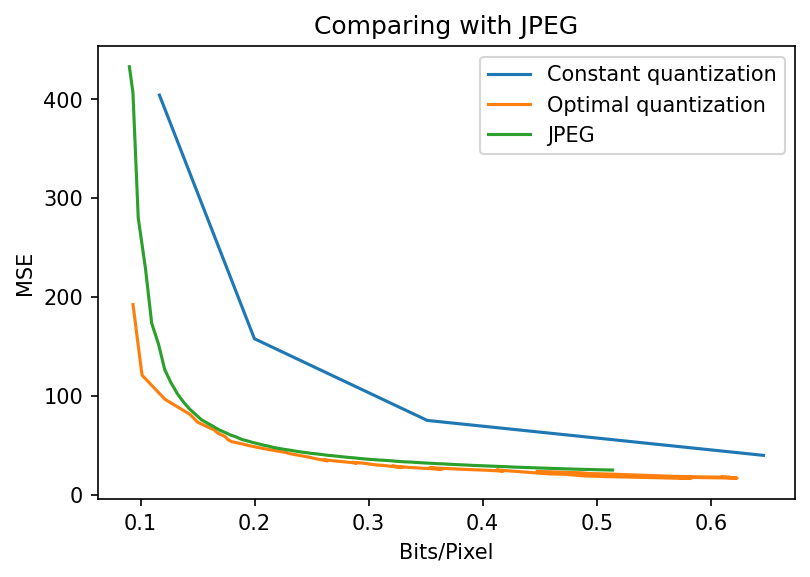

In [49]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points_subbands), label="Constant quantization")
pylab.plot(*zip(*optimal_RD_points), label="Optimal quantization")
pylab.plot(*zip(*JPEG_RD_points), label="JPEG")
pylab.title("Comparing with JPEG")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

In [45]:
with open('DCT.txt', 'w') as f:
    for item in optimal_RD_points:
        f.write(f"{item[0]}\t{item[1]}\n")

## Chroma subsampling

Our codec is 4:4:4 and JPEG is 4:2:0. 

We apply a Sinc to the chroma and subsample. 

## Computation of the RD slopes

In [ ]:
print(RD_points)

In [ ]:
for Q_step in range(len(Q_steps)):
    for i in range(block_y_side):
        for j in range(block_x_side):
            print(f"{RD_points[i * block_x_side + j][Q_step], end=' ')
    print()

In [ ]:
for i in range(block_y_side):
    for j in range(block_x_side):
        y_only_one_sb = np.zeros_like(y_sbs)
        #only_one_subband_y = np.copy(y)
        sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                   blocks_in_x*j:blocks_in_x*(j+1)]
        y_only_one_sb[blocks_in_y*i:blocks_in_y*(i+1),
                      blocks_in_x*j:blocks_in_x*(j+1)] = sb
        y_only_one_sb_blks = DCT.get_blocks(y_only_one_sb, block_y_side, block_x_side)
        z_only_one_sb = DCT.synthesize(y_only_one_sb_blks, block_y_side, block_x_side)
        #zz_only_one_sb = YUV.to_RGB(z_only_one_sb)
        MSE = distortion.MSE(x, z_only_one_sb)
        MSE_l.append(MSE)
        entropy = information.entropy((sb.astype(np.int16).flatten()))
        entropy_l.append(entropy)
        slope = (image_energy - MSE) / entropy
        print(i, j, image_energy, MSE, entropy, slope)

## Subband gains
The gain of each subband can be computed giving energy to a subband, performing the inverse transform, and measuring the energy of the reconstruction.

In [ ]:
blocks_in_y = 1024//block_y_side
blocks_in_x = 1024//block_x_side
y_only_one_sb = np.empty(shape=(1024, 1024))
for i in range(block_y_side):
    for j in range(block_x_side):
        y_only_one_sb[...] = 0.0
        y_only_one_sb[blocks_in_y*i:blocks_in_y*(i+1),
                      blocks_in_x*j:blocks_in_x*(j+1)] = 100.0
        y_only_one_sb_blks = DCT.get_blocks(y_only_one_sb, block_y_side, block_x_side)
        z_only_one_sb = DCT.synthesize(y_only_one_sb_blks, block_y_side, block_x_side)
        energy = distortion.average_energy(z_only_one_sb)
        print(int(energy), end=' ')
    print()

As it can be seen, the 8x8 DCT has (approximately) the same gain for all the subbands and therefore, the constant quantization is optimal from this point of view. Let's analyze now the information content of each subband.

## Dynamic range of the subbands
Some subbands (such as LL) has more energy than others. Notice, however, that energy is not equal to information.

In [ ]:
y = block_DCT.analyze(x, block_y_side, block_x_side)
y = block_DCT.get_subbands(y, block_y_side, block_x_side)
max_, min_ = block_DCT.compute_max_min(y, block_y_side, block_x_side)

In [ ]:
np.set_printoptions(edgeitems=8, linewidth=120, formatter=dict(float=lambda x: "%.3g" % x))
print(max_.astype(np.int32))

In [ ]:
print(min_.astype(np.int32))

## Variances of the subbands
The variance in each subband, however, is a good estimator of the information provided the subband.

In [ ]:
y = block_DCT.analyze(x, block_y_side, block_x_side)
y = block_DCT.get_subbands(y, block_y_side, block_x_side)
variances = block_DCT.compute_variances(y, block_y_side, block_x_side)

In [ ]:
np.set_printoptions(edgeitems=5, linewidth=100, formatter=dict(float=lambda x: "%.3g" % x))
print(variances.astype(np.int32))
print("max var =", variances.max(), "at", np.unravel_index(variances.argmax(), variances.shape))
print("min var =", variances.min(), "at", np.unravel_index(variances.argmin(), variances.shape))

As it can be seen, most of the information is stored in the low-frequency subbands.

## Quantizing depending on the variance
Lets quantize depending on the variance.

In [ ]:
xx = image.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)

variance_RD_points = []
for Q_step in [128,64,32,16,8,4,2,1]:
    y = block_DCT.analyze(x, block_y_side, block_x_side)
    y = block_DCT.get_subbands(y, block_y_side, block_x_side)
    variances = np.sqrt(block_DCT.compute_variances(y, block_y_side, block_x_side))
    normalized_variances = (variances - variances.min()) / (variances.max() - variances.min())
    Q_steps = Q_step / np.log(normalized_variances + 1.01)
    print(Q_steps.astype(np.int32))
    q_y = block_DCT.quantize(y, block_y_side, block_x_side, Q_steps)
    dq_y = block_DCT.dequantize(q_y, block_y_side, block_x_side, Q_steps)
    dq_y = block_DCT.get_blocks(dq_y, block_y_side, block_x_side)
    qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
    dq_zz = YUV.to_RGB(qd_z)
    #image.write(q_y, f"/tmp/{Q_step}_", 0)
    image.write((q_y.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/{Q_step}_", 0)
    bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
    MSE = distortion.MSE(xx, dq_zz)
    variance_RD_points.append((bits_per_pixel, MSE))
    print(Q_step)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*subband_RD_points), label="constant quantization")
pylab.plot(*zip(*variance_RD_points), label="variance-based quantization")
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

As it can be seen, varying the quantization step depending on the variance does not necessarily improves significatively the R/D tradeoff. This is a consequence of that the subband gains are approximately the same and therefore, the quantization noise remains constant among subbands.

## Quantizing depending on the variance with thresholding
Now, we set to zero all those quantization idexes that (in absolute value) are smaller than a threshold.

In [ ]:
xx = image.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)

threshold_RD_points = []
for Q_step in [128,64,32,16,8,4,2,1]:
    y = block_DCT.analyze(x, block_y_side, block_x_side)
    y = block_DCT.get_subbands(y, block_y_side, block_x_side)
    variances = np.sqrt(block_DCT.compute_variances(y, block_y_side, block_x_side))
    normalized_variances = (variances - variances.min()) / (variances.max() - variances.min())
    Q_steps = Q_step / np.log(normalized_variances + 1.01)
    print(Q_steps.astype(np.int32))
    q_y = block_DCT.quantize(y, block_y_side, block_x_side, Q_steps)
    q_y[ abs(q_y) < 3] = 0 
    dq_y = block_DCT.dequantize(q_y, block_y_side, block_x_side, Q_steps)
    dq_y = block_DCT.get_blocks(dq_y, block_y_side, block_x_side)
    qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
    dq_zz = YUV.to_RGB(qd_z)
    #image.write(q_y, f"/tmp/{Q_step}_", 0)
    image.write((q_y.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/{Q_step}_", 0)
    bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
    MSE = distortion.MSE(xx, dq_zz)
    threshold_RD_points.append((bits_per_pixel, MSE))
    print(Q_step)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*subband_RD_points), label="constant quantization")
pylab.plot(*zip(*threshold_RD_points), label="variance-based quantization with threshold")
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

And, as it can be seen, as it happens with a variable variance-based (wihtout thresholding) quantization step, the effect that we can reach lower bit-rates (obviously, increasing the distortion), although not better R/D tradeoffs.

## About the contribution of the subbands to the quality of the recostruction
Quantization can be also considered as a form of controlling how much information of the original image will be found in the reconstruction. Moreover, due to the DCT is orthogonal, DCT coefficients (and therefore, also the subbands) are uncorrelated, which implies that the contribution of each subband to the reconstruction is independent.

To check this we can:
1. Transform the image.
2. Generate the subbands.
3. Set to zero all the subband except one.
4. Restore the DCT-blocks.
5. Apply the inverse transform.
6. Transform the generated image.
7. Test if the resulting DCT image matches the DCT image used in the step 5. If matches (with some maximum error), the transform is orthogonal.

In [ ]:
xx = image.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = DCT.analyze(x, block_y_side, block_x_side)
y_sbs = DCT.get_subbands(y, block_y_side, block_x_side)
blocks_in_y = y.shape[0]//block_y_side
blocks_in_x = y.shape[1]//block_x_side

i_coordinate_to_keep = 1
j_coordinate_to_keep = 1
mask = np.zeros_like(y, bool)
mask[blocks_in_y*i_coordinate_to_keep:(blocks_in_y+1)*i_coordinate_to_keep,
     blocks_in_x*j_coordinate_to_keep:(blocks_in_x+1)*j_coordinate_to_keep] = True
y_sbs[~mask] = 0
y_blks = DCT.get_blocks(y_sbs, block_y_side, block_x_side)
y_blks_copy = np.copy(y_blks)
z = DCT.synthesize(y_blks, block_y_side, block_x_side)
y2 = DCT.analyze(z, block_y_side, block_x_side)
print((y2 == y_blks_copy).all())
print((y2[~mask] == 0).all())

Therefore, the DCT is orthogonal.

## R/D performance

## Is the B-DCT orthogonal (and orthonormal)?
Orthogonality implies that the contributions of the distortion of the subbands to the distortion of the reconstructed image are additive. Orthonormality that the contributions are the same.

## Contribution of each subband to the distortion of the reconstruction
The DCT is orthogonal. This means that the DCT coefficients are uncorrelated, or in other words, that the quantization error generated in one coefficient (or subband) is not correlated with the quantization error generated in other coefficients (or subbands).

Following this reasoaning, we can assume that the quantization noise

We perform the inverse transform of the subband decomposition considering only one subband (zeroing the rest) and measuring the MSE between the reconstructed image and the original one.

In [ ]:
xx = image.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = DCT.analyze(x, block_y_side, block_x_side)
y_sbs = DCT.get_subbands(y, block_y_side, block_x_side)
blocks_in_y = y.shape[0]//block_y_side
blocks_in_x = y.shape[1]//block_x_side
image_energy = distortion.average_energy(x) # DCT is unitary, i.e., energy(x) = energy(y)
print(distortion.average_energy(y))
MSE_l = []
entropy_l = []
for i in range(block_y_side):
    for j in range(block_x_side):
        y_only_one_sb = np.zeros_like(y_sbs)
        #only_one_subband_y = np.copy(y)
        sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                   blocks_in_x*j:blocks_in_x*(j+1)]
        y_only_one_sb[blocks_in_y*i:blocks_in_y*(i+1),
                      blocks_in_x*j:blocks_in_x*(j+1)] = sb
        y_only_one_sb_blks = DCT.get_blocks(y_only_one_sb, block_y_side, block_x_side)
        z_only_one_sb = DCT.synthesize(y_only_one_sb_blks, block_y_side, block_x_side)
        #zz_only_one_sb = YUV.to_RGB(z_only_one_sb)
        MSE = distortion.MSE(x, z_only_one_sb)
        MSE_l.append(MSE)
        entropy = information.entropy((sb.astype(np.int16).flatten()))
        entropy_l.append(entropy)
        slope = (image_energy - MSE) / entropy
        print(i, j, image_energy, MSE, entropy, slope)

In [ ]:
print("Entropy:")
for i in range(block_y_side):
    for j in range(block_x_side):
        entropy = entropy_l[i*block_x_side+j]
        print(f"{entropy:7.2f}", end=' ')
    print()
print("MSE:")
for i in range(block_y_side):
    for j in range(block_x_side):
        MSE = MSE_l[i*block_x_side+j]
        print(f"{MSE:7.2f}", end=' ')
    print()
print("MSE improvement:")
for i in range(block_y_side):
    for j in range(block_x_side):
        improvement = image_energy - MSE_l[i*block_x_side+j]
        print(f"{improvement:7.2f}", end=' ')
    print()
print("Slope:")
for i in range(block_y_side):
    for j in range(block_x_side):
        slope = (image_energy - MSE_l[i*block_x_side+j]) / entropy_l[i*block_x_side+j]
        print(f"{slope:7.2f}", end=' ')
    print()

It can be seen that the subband LL and its neighborhood contribute more to the quality of the reconstruction (in terms of R/D) than the others. These differences depends on the correlation between the original image and the (2D) basis functions corresponding to each subband.

## 

## A manual search of the optimal sequence of quantization steps per subband
For the sake of simpliticy, let's suppose that only the quantization steps [128, 54, 32, 16, 8, 4, 2, 1] are available. We will work only with 16 subbands, for the same reason.

This creates a search tree of nodes where each one represents a relative , where there is sequence of nodes

In [ ]:
xx = image.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = DCT.analyze(x, block_y_side, block_x_side)
y_sbs = DCT.get_subbands(y, block_y_side, block_x_side)
blocks_in_y = y.shape[0]//block_y_side
blocks_in_x = y.shape[1]//block_x_side
image_energy = distortion.average_energy(x) # DCT is unitary, i.e., energy(x) = energy(y)
print(image_energy)


### Considering only L4L4.Q=128

In [ ]:
i = 0
j = 0
Q_step = 128
MSEs_LL = []
entropies_LL = []
y_progressive = np.zeros_like(y_sbs)
sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
           blocks_in_x*j:blocks_in_x*(j+1)]
Q_sb = Q.dequantize(Q.quantize(sb, Q_step), Q_step)
y_progressive[blocks_in_y*i:blocks_in_y*(i+1),
              blocks_in_x*j:blocks_in_x*(j+1)] = Q_sb
y_blks_prog = DCT.get_blocks(y_progressive, block_y_side, block_x_side)
z_prog = DCT.synthesize(y_blks_prog, block_y_side, block_x_side)
MSE = distortion.MSE(x, z_prog)
entropy = information.entropy((Q_sb.astype(np.int16).flatten()))
slope = (image_energy - MSE) / entropy
print("Delta MSE =", MSE, "Delta Entropy =", entropy, "Slope =", slope)
MSEs_LL.append(MSE)
entropies_LL.append(entropy)

### After S[0, 0].Q=128, considering S[0, 0].Q=64

In [ ]:
i = 0
j = 0
Q_step = 64
sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
           blocks_in_x*j:blocks_in_x*(j+1)]
Q_sb = Q.dequantize(Q.quantize(sb, Q_step), Q_step)
y_progressive[blocks_in_y*i:blocks_in_y*(i+1),
              blocks_in_x*j:blocks_in_x*(j+1)] = Q_sb
y_blks_prog = DCT.get_blocks(y_progressive, block_y_side, block_x_side)
z_prog = DCT.synthesize(y_blks_prog, block_y_side, block_x_side)
MSE = distortion.MSE(x, z_prog)
delta_MSE = MSEs_LL[0] - MSE
entropy = information.entropy((Q_sb.astype(np.int16).flatten()))
delta_entropy = entropy - entropies_LL[0]
slope = delta_MSE / delta_entropy
print("Delta MSE =", delta_MSE, "Delta_entropy =", delta_entropy, "slope =", slope)
MSEs_LL.append(MSE)
entropies_LL.append(entropy)

### After S[0, 0].Q=128, considering S[0, 1].Q=128

In [ ]:
i = 0
j = 0
Q_step = 128
sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
           blocks_in_x*j:blocks_in_x*(j+1)]
Q_sb = Q.dequantize(Q.quantize(sb, Q_step), Q_step)
y_progressive[blocks_in_y*i:blocks_in_y*(i+1),
              blocks_in_x*j:blocks_in_x*(j+1)] = Q_sb
i = 0
j = 1
Q_step = 128
sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
           blocks_in_x*j:blocks_in_x*(j+1)]
Q_sb = Q.dequantize(Q.quantize(sb, Q_step), Q_step)
y_progressive[blocks_in_y*i:blocks_in_y*(i+1),
              blocks_in_x*j:blocks_in_x*(j+1)] = Q_sb
y_blks_prog = DCT.get_blocks(y_progressive, block_y_side, block_x_side)
z_prog = DCT.synthesize(y_blks_prog, block_y_side, block_x_side)
MSE = distortion.MSE(x, z_prog)
delta_MSE = MSEs_LL[0] - MSE
entropy = information.entropy((Q_sb.astype(np.int16).flatten()))
delta_entropy = entropy - entropies_LL[0]
slope = delta_MSE / delta_entropy
print("Delta MSE =", delta_MSE, "Delta_entropy =", delta_entropy, "slope =", slope)
MSEs_LL.append(MSE)
entropies_LL.append(entropy)

In [ ]:
image_energy = distortion.average_energy(x) # DCT is unitary, i.e., energy(x) = energy(y)
print(distortion.average_energy(y))
MSE_l = []
entropy_l = []
for i in range(block_y_side):
    for j in range(block_x_side):
        y_only_one_sb = np.zeros_like(y_sbs)
        #only_one_subband_y = np.copy(y)
        sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                   blocks_in_x*j:blocks_in_x*(j+1)]
        y_only_one_sb[blocks_in_y*i:blocks_in_y*(i+1),
                      blocks_in_x*j:blocks_in_x*(j+1)] = sb
        y_only_one_sb_blks = DCT.get_blocks(y_only_one_sb, block_y_side, block_x_side)
        z_only_one_sb = DCT.synthesize(y_only_one_sb_blks, block_y_side, block_x_side)
        zz_only_one_sb = YUV.to_RGB(z_only_one_sb)
        MSE = distortion.MSE(x, z_only_one_sb)
        MSE_l.append(MSE)
        entropy = information.entropy((sb.astype(np.int16).flatten()))
        entropy_l.append(entropy)
        slope = (image_energy - MSE) / entropy
        print(i, j, image_energy, MSE, entropy, slope)

In [ ]:
xx = image.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = DCT.analyze(x, block_y_side, block_x_side)
y_sbs = DCT.get_subbands(y, block_y_side, block_x_side)
blocks_in_y = y.shape[0]//block_y_side
blocks_in_x = y.shape[1]//block_x_side

print("Accumulated subband distortions:")
accum_RD_points = []
y_accum_sbs = np.zeros_like(y_sbs)
for i in range(block_y_side):
    for j in range(block_x_side):
        if i!=0 and j!=0:
            sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                       blocks_in_x*j:blocks_in_x*(j+1)]
            y_accum_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                        blocks_in_x*j:blocks_in_x*(j+1)] = sb
            y_accum_sbs_blks = DCT.get_blocks(y_accum_sbs, block_y_side, block_x_side)
            z_accum_sbs = DCT.synthesize(y_accum_sbs_blks, block_y_side, block_x_side)
            zz_accum_sbs = YUV.to_RGB(z_accum_sbs)
            MSE = distortion.MSE(xx, zz_accum_sbs)
            print(i, j, MSE)
            accum_RD_points.append((i*block_y_side+j, MSE))

In [ ]:
pylab.figure(dpi=150)
subband_index = np.arange(0, block_y_side*block_x_side, 0.01)
pylab.plot(subband_index, 1/subband_index, label="1/x")
pylab.plot(*zip(*accum_RD_points), label="optimal quantization")
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("subband index")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

In the case of the B-DCT, all subbands have a similar gain. Therefore, al subbands should be quantized with the same quantization step.

## R/D optimization
The quantization steps should operate in each subband with the same RD-slope.

In [ ]:
xx = image.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)

optimal_RD_points = []
for Q_step in [128,64,32,16,8,4,2,1]:
    y = block_DCT.analyze(x, block_y_side, block_x_side)
    y = block_DCT.get_subbands(y, block_y_side, block_x_side)
    #slopes = block_DCT.get_slopes(y, block_y_side, block_x_side, Q_step)
    Q_steps, slopes = block_DCT.find_optimal_Q_steps(y, block_y_side, block_x_side, Q_step)
    print(Q_steps.astype(np.int32))
    q_y = block_DCT.quantize(y, block_y_side, block_x_side, Q_steps)
    dq_y = block_DCT.dequantize(q_y, block_y_side, block_x_side, Q_steps)
    dq_y = block_DCT.get_blocks(dq_y, block_y_side, block_x_side)
    qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
    dq_zz = YUV.to_RGB(qd_z)
    image.write((q_y.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/{Q_step}_", 0)
    bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
    MSE = distortion.MSE(xx, dq_zz)
    optimal_RD_points.append((bits_per_pixel, MSE))
    print(Q_step, end=' ', flush=True)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*variance_RD_points), label="variance quantization")
pylab.plot(*zip(*optimal_RD_points), label="optimal quantization")
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

### A special situation

In [ ]:
special_RD_points = []
xx = image.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = block_DCT.analyze(x, block_y_side, block_x_side)
y = block_DCT.get_subbands(y, block_y_side, block_x_side)
Q_steps = np.full(shape=(block_y_side, block_x_side), dtype=np.float32, fill_value=100000)
Q_steps[0, 0] = 128
q_y = block_DCT.quantize(y, block_y_side, block_x_side, Q_steps)
show_RGB_image(255*normalize(YUV.to_RGB(q_y)), "Quantized subbands")
blocks_in_y = x.shape[0]//block_y_side
blocks_in_x = x.shape[1]//block_x_side
show_RGB_image(255*normalize(YUV.to_RGB(q_y[:blocks_in_y, :blocks_in_x])), f"L{block_y_side}L{block_x_side} quantized subband detail")
dq_y = block_DCT.dequantize(q_y, block_y_side, block_x_side, Q_steps)
dq_y = block_DCT.get_blocks(dq_y, block_y_side, block_x_side)
qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
dq_zz = YUV.to_RGB(qd_z)
show_RGB_image(255*normalize(dq_zz), "Reconstruction")
image.write((q_y.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/{Q_step}_", 0)
bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
MSE = distortion.MSE(xx, dq_zz)
special_RD_points.append((bits_per_pixel, MSE))

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*variance_RD_points), label="variance quantization")
pylab.plot(*zip(*optimal_RD_points), label="optimal quantization")
pylab.plot(*zip(*special_RD_points), label="special quantization", marker='o')
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

In [ ]:
## Operational RD curve

In [ ]:
xx = image.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = block_DCT.analyze(x, block_y_side, block_x_side)
y = block_DCT.get_subbands(y, block_y_side, block_x_side)
blocks_in_y = y.shape[0]//block_y_side
blocks_in_x = y.shape[1]//block_x_side
for i in range(block_y_side):
    for j in range(block_x_side):
        subband = y[blocks_in_y*i:blocks_in_y*(i+1),
                    blocks_in_x*j:blocks_in_x*(j+1)][..., 0]
        RD_curve = []
        for Q_step in [128,64,32,16,8,4,2,1]:
            Q_subband = Q.quantize(subband, Q_step)
            d_Q_subband = Q.dequantize(Q_subband, Q_step)
            RD_point = (information.entropy(d_Q_subband.flatten().astype(np.int16)),
                       distortion.MSE(subband,d_Q_subband))
            RD_curve.append(RD_point)
            
        pylab.plot(*zip(*RD_curve), label='')
        pylab.title(f"{i} {j}")
        pylab.xlabel("bits/pixel")
        pylab.ylabel("MSE")
        plt.legend(loc="best")
        pylab.show()

In [ ]:
blocks_in_y = x.shape[0]//block_y_side
blocks_in_x = x.shape[1]//block_x_side
show_RGB_image(255*normalize(cor_dq_y[:blocks_in_y, :blocks_in_x]), f"L{block_y_side}L{block_x_side} subband detail")
show_RGB_image(255*normalize(cor_dq_y[:blocks_in_y, blocks_in_x:2*blocks_in_x]), f"L{block_y_side}H{block_x_side-1} subband detail")
show_RGB_image(255*normalize(cor_dq_y[blocks_in_y:2*blocks_in_y, :blocks_in_x]), f"L{block_y_side-1}H{block_x_side} subband detail")


In [ ]:
q_step = 128
y = block_DCT.analyze(x, block_y_side, block_x_side)
y = block_DCT.get_subbands(y, block_y_side, block_x_side)
variances = block_DCT.compute_variances(y, block_y_side, block_x_side)
print(variances.max(), np.unravel_index(variances.argmax(), variances.shape))

## Testing `block_DCT.find_optimal_Q_steps()`

In [ ]:
q_step = 16
y = block_DCT.analyze(x, block_y_side, block_x_side)
y = block_DCT.get_subbands(y, block_y_side, block_x_side)
print(block_DCT.compute_slopes(y, block_y_side, block_x_side, Q_step).astype(np.int32))

In [ ]:
Q_steps, slopes = block_DCT.find_optimal_Q_steps(y, block_y_side, block_x_side, Q_step)

In [ ]:
print(Q_steps, slopes.astype(np.int32))

In [ ]:
q_y = block_DCT.quantize(y, block_y_side, block_x_side, Q_steps)
dq_y = block_DCT.dequantize(q_y, block_y_side, block_x_side, Q_steps)
dq_y = block_DCT.get_blocks(dq_y, block_y_side, block_x_side)
z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)

In [ ]:
show_RGB_image(np.clip(z, a_max=255, a_min=0), "Dequantized (using optimal quantization steps) image")

## Computing the variance of the DCT coefficients

In [ ]:
y = block_DCT.analyze(x, block_y_side, block_x_side)
q_y = block_DCT.constant_quantize(y, block_y_side, block_x_side, 128)
v = block_DCT.compute_variances(q_y, block_y_side, block_x_side)

In [ ]:
print(v)

## Quantizing the YCoCg/B-DCT domain

### Using constant quantization

### Using "optimal" quantization

In [ ]:
xx = image.read(f"../sequences/stockholm/", 0)
x = YUV.from_RGB(xx.astype(np.int16))

constant_RD_points = []
optimal_RD_points = []
for Q_step in [128,64,32,16,8,4,2,1]:
    print(Q_step, end=' ', flush=True)
    y = block_DCT.analyze(x, block_y_side, block_x_side)
    
    # Constant quantization
    q_y = block_DCT.constant_quantize(y, block_y_side, block_x_side, Q_step)
    dq_y = block_DCT.constant_dequantize(q_y, block_y_side, block_x_side, Q_step)
    qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
    dq_zz = YUV.to_RGB(qd_z)
    subband_q_y = block_DCT.create_subbands(q_y, block_y_side, block_x_side)
    image.write(subband_q_y, f"/tmp/{Q_step}_", 0)
    bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
    MSE = distortion.MSE(xx, dq_zz)
    constant_RD_points.append((bits_per_pixel, MSE))

    # Optimal quantization
    slopes, Q_steps = block_DCT.get_slopes(y, block_y_side, block_x_side, Q_step)
    target_slope = np.median(slopes)
    Q_steps, new_slopes = block_DCT.find_optimal_Q_steps(y, block_y_side, block_x_side, Q_steps, slopes, target_slope)
    print(f"current={slopes.astype(np.int16)}\ntarget_slope={target_slope}\nnew={new_slopes.astype(np.int16)}\nQ_steps={Q_steps}")
    print(slopes.max(), slopes.min())
    print(new_slopes.max(), new_slopes.min())
    q_y = block_DCT.quantize(y, block_y_side, block_x_side, Q_steps)
    dq_y = block_DCT.dequantize(q_y, block_y_side, block_x_side, Q_steps)
    qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
    dq_zz = YUV.to_RGB(qd_z)
    subband_q_y = block_DCT.create_subbands(q_y, block_y_side, block_x_side)
    image.write(subband_q_y, f"/tmp/{Q_step}_", 0)
    bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
    MSE = distortion.MSE(xx, dq_zz)
    optimal_RD_points.append((bits_per_pixel, MSE))

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*constant_RD_points), label="constant quantized B-DCT")
pylab.plot(*zip(*optimal_RD_points), label="optimal quantized B-DCT")
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

In [ ]:
Q_steps

In [ ]:
slopes

In [ ]:
new_slopes